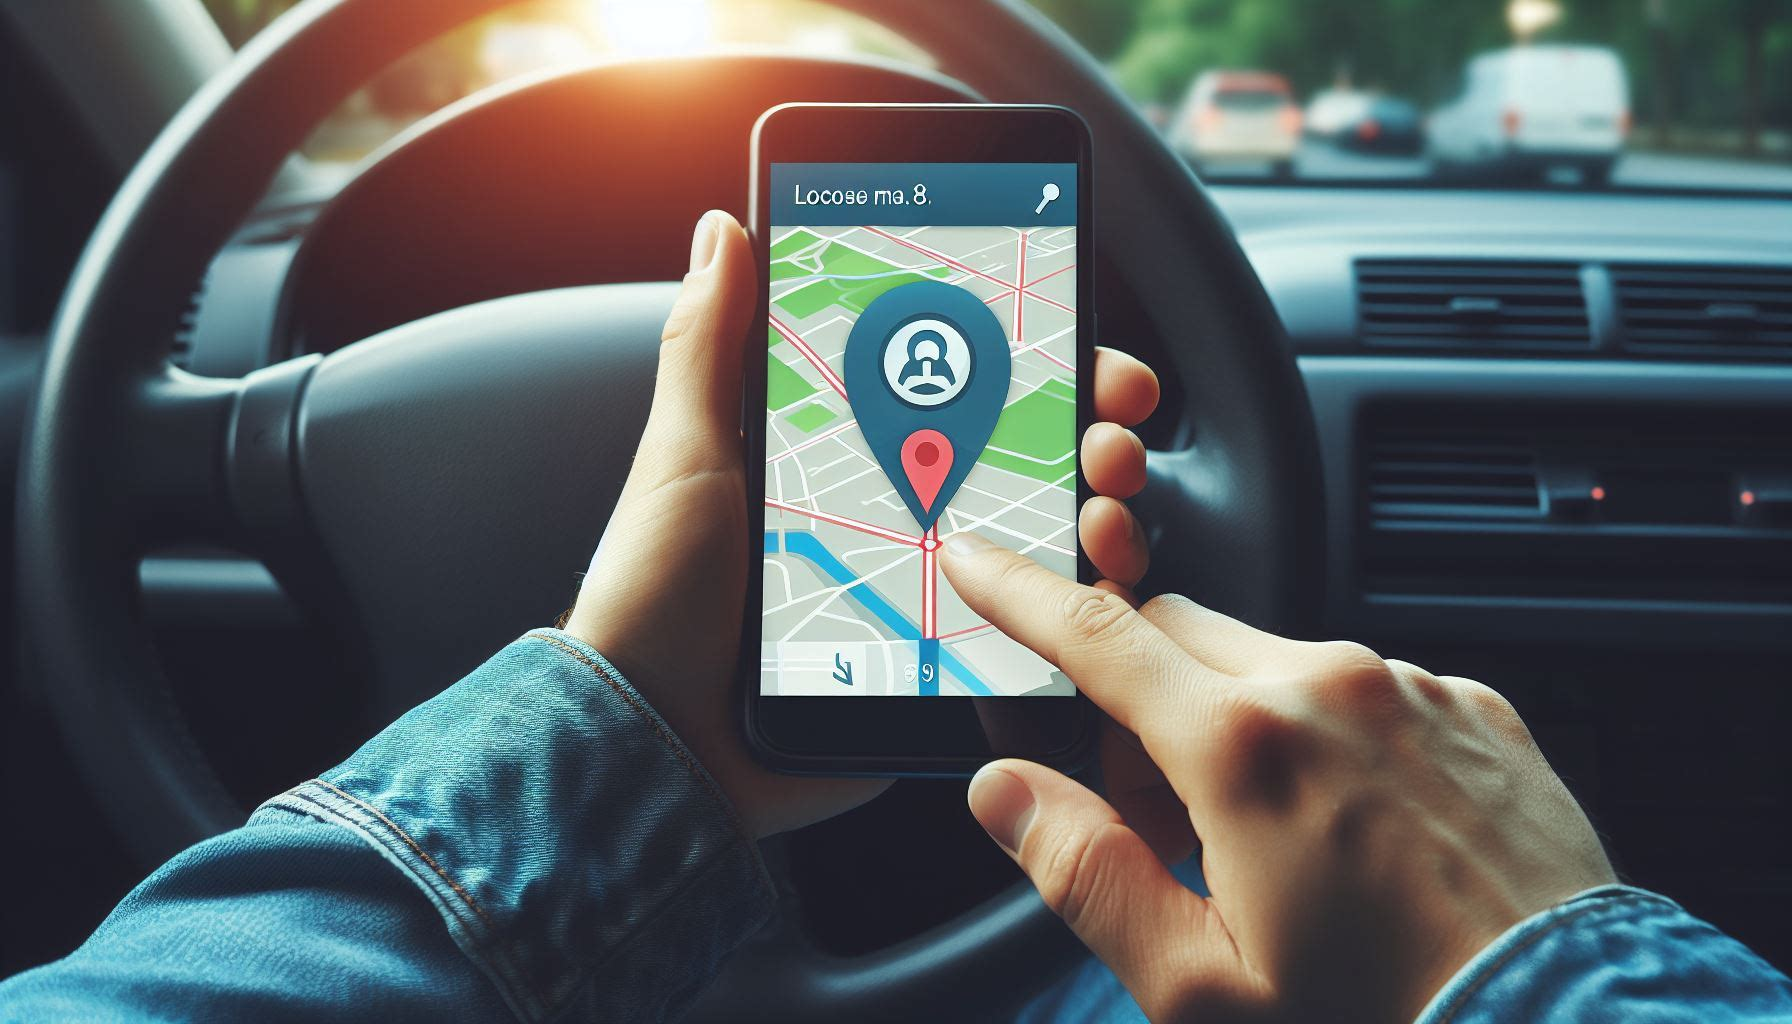

In [1]:
from IPython.display import Image
Image("../input/waze-user-churn/Designer.png")

#### **Welcome to the final phase of the Waze User Churn Prediction Project!**
In this concluding phase of our project, we are moving beyond the logistic regression model to explore more advanced techniques using **Random Forest** and **XGBoost**. Our aim is to enhance the predictive performance and effectiveness of our churn prediction model. Previously, we completed key stages including **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/waze-exploratory-data-analysis)**, **[Hypothesis Testing](https://www.kaggle.com/code/lekhatopil/hypotheses-two-sample-t-tests-chi-squared-test)**, and the development of a **[Logistic Regression Model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)**.

# **About the Company**
Waze, a free navigation app owned by Google, makes it easier for drivers around the world to reach their destinations. Waze's community of map editors, beta testers, translators, partners, and users helps make each drive better and safer.

# **Project Goal**
Develop a machine learning model to predict user churn. An accurate model will help prevent churn, improve user retention, and contribute to the growth of Waze's business.

### **Before proceeding, let's address some important questions:**

## **1. What are you being asked to do?**
* Predict whether a customer will churn or remain retained on Waze app.

## **2. What are the ethical implications of the model? What are the consequences of your model making errors?**
  #### **1. What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will (Type II Error))?**
   * Waze may miss the opportunity to take proactive steps to retain users who are likely to stop using the app.
   
   * By accurately identifying **at-risk users**, Waze can implement targeted strategies such as sending personalized emails showcasing app features, providing tips for seamless navigation, or conducting surveys to understand user pain points and reasons for potential churn.

#### **2. What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't (Type I Error))?**
  * Waze may take unnecessary proactive steps to retain users who were **not at-risk of churning**, potentially leading to actions that could annoy or irritate loyal users.
  * This can result in increased user dissatisfaction due to frequent and unnecessary emails or notifications, affecting user experience.

It's crucial to strike a balance in model accuracy to minimize both false positives and false negatives. This ensures that proactive retention efforts are targeted specifically toward users at risk of churning, while avoiding any inconvenience or annoyance to other users who are not likely to churn.

# **3. Do the benefits of such a model outweigh the potential problems?**
* If the model performs well, it can help Waze identify users who are at risk of churning, enabling the company to implement proactive retention efforts and ultimately increase retention rates.
* However, there are ethical considerations related to false predictions (false positives and false negatives). False positives could cause unnecessary interventions with loyal users, while false negatives might mean missed opportunities to **retain at-risk users**.





# **Import Necessary Packages & Load Dataset**

In [2]:
# Import standard operational packages
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# function that helps plot feature importance
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/waze-user-churn/Designer.png
/kaggle/input/waze-dataset-to-predict-user-churn/waze_dataset.csv


In [3]:
# Read Data
df = pd.read_csv('../input/waze-dataset-to-predict-user-churn/waze_dataset.csv', encoding = 'unicode_escape')

In [4]:
# Display
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


# **Feature engineering**

### **1. km_per_driving_day**
* We will create a new feature called **`km_per_driving_day`**, which calculates the mean distance driven per driving day for each user. This will be achieved by dividing the total kilometers driven (**`driven_km_drives`**) by the number of driving days (**`driving_days`**).

There are some users with zero **`driving_days`**, causing Pandas to assign infinity (inf) values to the corresponding rows in the new column due to undefined division by zero. Therefore, it is necessary to convert these infinite values to zero.

In [6]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Descriptive Statistics
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

### **2. percent_sessions_in_last_month**
* Next, we will create the **`percent_sessions_in_last_month`** feature by dividing the number of monthly sessions (**`sessions`**) by the estimated total sessions (**`total_sessions`**) since the user onboarded.
* This new variable will help us understand the proportion of total sessions that occurred within the last month since user onboarded.

In [7]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Descriptive Statistics
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

Based on our **[EDA](https://www.kaggle.com/code/lekhatopil/waze-exploratory-data-analysis)**, we discovered that **50%** of users have **40%** or more of their **sessions** occurring within the last month. This finding suggests that the **`percent_sessions_in_last_month`** feature could be a valuable predictor for our model.

### **3. professional_driver**
The next feature we will create is **`professional_driver`**, which identifies users based on specific thresholds for the number of drives (**`drives`**) and driving days (**`driving_days`**) in the last month. To be labeled as a **`professional_driver`**, a user must meet both of the following conditions:

1. The user should have completed **60** or more drives (**`drives`**) in the last month.
2. The user should have driven for **15** or more days (**`driving_days`**) in the last month.

In [8]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives']>=60) & (df['driving_days'] >=15), 1, 0)

# Display
df[['drives', 'driving_days', 'professional_driver']].head()

,drives,driving_days,professional_driver
0,226,19,1
1,107,11,0
2,95,8,0
3,40,3,0
4,68,18,1


In our previous **[Logistic Regression Model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)**, this feature ranked as the third most important predictor based on its **coefficient** in the feature importance.

### **4. total_sessions_per_day**

The next feature will be **`total_sessions_per_day`**, representing the mean number of **sessions** per day since onboarding.
* **`sessions`**: The number of occurrence of a user opening the app during the month.
* **`total_sessions`**: A model estimate of the total number of sessions since a user has onboarded.


In [9]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Descriptive Statistic
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

### **5. km_per_hour**
km_per_hour represents the mean kilometers per hour driven in the last month. It is calculated by dividing **`driven_km_drives`** by **`duration_minutes_drives`** and converting the result into hours by further dividing by **60**.
* **`driven_km_drives`**: Total kilometers driven during the month.
* **`duration_minutes_drives`**: Total duration driven in minutes during the month.

In [10]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / df['duration_minutes_drives'] / 60

# Descriptive Statistics
df['km_per_hour'].describe()

count    14999.000000
mean         0.052887
std          0.092965
min          0.020004
25%          0.025196
50%          0.033995
75%          0.053647
max          6.567478
Name: km_per_hour, dtype: float64

### **6. km_per_drive**
**`km_per_drive`** represents the mean number of **kilometers driven per drive** made by each user in the last month.
* **`driven_km_drives`**: Total kilometers driven during the month.
* **`drives`**: Total duration driven in minutes during the month.



In [11]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Descriptive Statistic
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

### **7. percent_of_sessions_to_favorite**
* Finally, we will create **`percent_of_sessions_to_favorite`**, which represents the percentage of total sessions directed towards a user's favorite places.
* We lack data on the **total drives since users onboarded**, we will use **`total_sessions`** as a reasonable estimate or proxy for the total number of drives.

This approach enables us to gain insights into user behavior and preferences based on the available data.

In [12]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] +
                                         df['total_navigations_fav2']) / df['total_sessions']

df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

Users whose drives to **non-favorite** places constitute a higher percentage of their total drives might be l**ess likely to churn**, as they are exploring new locations. Conversely, users who allocate a higher percentage of their drives to **favorite places** might be **more likely to churn**, possibly due to their familiarity with the routes.

# **Drop Missing Values**
During our previous **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/waze-exploratory-data-analysis)**, we identified **700** missing values in the dataset. These missing values are believed to be **missing at random (MAR)**, as there is no evidence of a non-random cause. Given that the missing values represent less than **5%** of the total dataset, removing them is unlikely to have a significant impact on the dataset's integrity.

In [13]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

# Dimension after removig missing data
print('Dimension after removing missing data:', df.shape)

Dimension after removing missing data: (14299, 20)


# **Outliers**

Based on our earlier **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/waze-exploratory-data-analysis)**, we identified outliers and extreme values in several columns. However, tree-based models are robust to outliers, eliminating the need for imputation or outlier removal.

# **Feature Selection**

Our **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/waze-exploratory-data-analysis)** revealed strong correlations among certain variables, indicating multicollinearity. Given that tree-based models can effectively manage collinearities between independent variables, there is no need to remove any variables except the **`ID`** column, which holds no relevance to churn prediction.

In [14]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

# **Variable Encoding**
### **Dummying Features**
We have one categorical variable, **`device`**, among our independent variables, which consists of two groups: **iPhone** and **Android**. While there are several methods available, such as **pd.get_dummies()** or **OneHotEncoder()**, for encoding categorical variables, we will use a simple approach with **np.where():**

* Assign **1** for **iPhone**
* Assign **0** for **Android**

In [15]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)

# Check
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


# **Target Encoding**
Lastly, we will encode the target variable label into binary format:

* Assign **0** for all **Retained**
* Assign **1** for all **Churned**

In [16]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)

# Check
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


# **Class Balance & Evaluation metric**










In [17]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True) * 100

label
retained    82.264494
churned     17.735506
Name: proportion, dtype: float64

* Our dataset shows class imbalance, with **17.73%** of users churned and **82.26%** retained—typical for churn prediction datasets. Although the imbalance is noticeable, it is not extreme and can be addressed without rebalancing classes. Tree-based models like Random Forest and XGBoost excel in handling such imbalances.

* For our imbalanced dataset, accuracy is an unsuitable evaluation metric. A false positive, where the model incorrectly predicts churn for a user who will actually stay, might lead to unnecessary retention measures, potentially irritating users. However, false positives do not result in direct financial losses or other significant consequences.

* On the other hand, false negatives, where the model fails to predict churn for users who actually churn, are critical. The company cannot afford false negatives because they prevent proactive measures to retain **at-risk users**, potentially increasing the churn rate. Therefore, we will prioritize selecting the model based on the **recall** score.

# **Construct Model**
## **Modeling workflow and model selection process**
The final dataset used for modeling consists of **14,299** samples, which is on the lower end of what is typically considered sufficient for conducting a robust model selection process. However, it still provides an adequate basis for our analysis.

# **Split the data**
* Split the data into train/validation/test sets (**60/20/20**)

### **We will follow these steps:**
1. Define **X**
2. Define **y**
3. Split the data into an interim **training set** and a **test set** using an **80/20** ratio.
4. Further split the interim training set into a **training set** and a **validation set** using a **75/25** ratio, resulting in a final ratio of **60/20/20** for **training/validation/test sets**.



In [18]:
# Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# Isolate y variable
y = df['label2']

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

Now, let's verify the number of samples in the partitioned data.


In [19]:
# Check the length of the data
data_len = [len(x) for x in (X_train, X_val, X_test)]
data_len

[8579, 2860, 2860]

# **Constructing the Random Forest Classifier**

In [20]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params  = {'max_depth': [None],
              'max_features': [1.0],
              'max_samples': [1.0],
              'min_samples_leaf': [2],
              'min_samples_split':[2],
              'n_estimators': [300]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [21]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 115 ms, total: 2min 26s
Wall time: 2min 26s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

In [22]:
# Examine best score
rf_cv.best_score_

0.12678201409034398

In [23]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [24]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
       model_name (string): what you want the model to be called in the output table (name of the model)
       model_object: a fit GridSearchCV object
       metric (string): precision, recall, f1, and accuracy

   Returns a pandas df with precision, recall, f1, and accuracy scores
   for the model with the best mean 'metric' score across all validation folds.
   '''

    # Map the metric name to the corresponding column in cv_results
    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Extract cv_results from the GridSearchCV object
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Identify the row index with the maximum value for the specified metric
    best_index = cv_results[metric_dict[metric]].idxmax()

    # Retrieve the metrics for the best-performing model configuration
    metrics = {
        'model': model_name,
        'precision': cv_results.loc[best_index, 'mean_test_precision'],
        'recall': cv_results.loc[best_index, 'mean_test_recall'],
        'F1': cv_results.loc[best_index, 'mean_test_f1'],
        'accuracy': cv_results.loc[best_index, 'mean_test_accuracy']
    }

    # Create a DataFrame containing the extracted metrics
    result_table = pd.DataFrame(metrics, index=[0])

    return result_table

In [25]:
# Get the scores
results = make_results('RF CV', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.458198,0.126782,0.198534,0.818626


* The **precision**, **recall**, and **F1** scores from the **Random Forest model** are below the desired thresholds.

* The recall for the Random Forest model is **0.12**, indicating that the model predicts more **false negatives**. A recall of **0.12** means that only **12%** of the actual churned cases are correctly identified by the model. In other words, the model **misses a significant portion of users who actually churned**, failing to capture them in its predictions.

* Compared to our previous **[Logistic Regression model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)**, the recall has improved from **0.09** to **0.12** in the Random Forest model, representing a **33%** increase.

* However, precision decreased from **0.52** (**[Logistic Regression model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)**) to **0.458**, and the F1-score showed a slight improvement from **0.16** (**[Logistic Regression model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)**) to **0.199**. Lastly, accuracy remains almost the same between the two models.

# **Constructing the XGBoost Classifier**

In [26]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }
# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [27]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 59s, sys: 1.3 s, total: 3min 1s
Wall time: 46.3 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

In [28]:
# Examine best score
xgb_cv.best_score_

0.1708264263019754

In [29]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [30]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB CV', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)

results

,model,precision,recall,F1,accuracy
0,RF CV,0.458198,0.126782,0.198534,0.818626
0,XGB CV,0.425932,0.170826,0.243736,0.811866


* The XGBoost model performs better compared to the Random Forest model, particularly with its **recall** score, which is nearly double that of the Logistic Regression model and about **35%** higher than the Random Forest model.

* However, despite these improvements, the XGBoost model can only capture around **17%** of actual churned cases, indicating a notable presence of false negatives.  

* Additionally, while precision has slightly decreased, the F1-score shows improvement over both **[Logistic Regression model](https://www.kaggle.com/code/lekhatopil/waze-logistic-regression-for-user-churn-prediction)** and Random Forest models.



# **Model selection**
Now let's make predictions on the validation set using both the Random Forest and XGBoost models. We will evaluate their performance, and the model that performs better on the validation set will be selected as the champion model.

For this purpose, we will define a function called **get_test_scores()** to generate a table of scores based on the predictions made on the validation data.

## **Random Forest**

In [31]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [32]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): name of the model of your choice
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    # Calculate evaluation metrics
    metrics = {
        'precision': precision_score,
        'recall': recall_score,
        'F1': f1_score,
        'accuracy': accuracy_score
    }
    
    scores = {metric: metrics[metric](y_test_data, preds) for metric in metrics}

    # Create DataFrame
    table = pd.DataFrame({
        'model': [model_name],
        **scores
    })

    return table


In [33]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF Val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.458198,0.126782,0.198534,0.818626
0,XGB CV,0.425932,0.170826,0.243736,0.811866
0,RF Val,0.445255,0.120316,0.189441,0.817483


The scores for the validation set (RF Val) are slightly lower compared to the training set (RF CV). The degree of variation in scores between the training and validation sets is within an acceptable range, suggesting that the model is not overfitting the training data.

## **XGBoost**

In [34]:
# XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.458198,0.126782,0.198534,0.818626
0,XGB CV,0.425932,0.170826,0.243736,0.811866
0,RF Val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238


* The XGBoost model's performance on the validation set (XGB Val) shows a slight decrease in scores compared to the training set (XGB CV).

* This minor decline falls within an acceptable range, suggesting that the XGBoost model did not overfit the training data.

* Among the evaluated models (Random Forest and XGBoost), the XGBoost model emerges as the clear champion based on its performance on the validation set.

# **Use Champion Model to Predict on Test data**
As the XGBoost model performed better compared to the **random forest** and **logistic regression models**, we will proceed by using the **XGBoost model** to make predictions on the test dataset. This step will allow us to assess the model's performance on new and unseen data, providing insights into its effectiveness for future predictions.


In [35]:
# XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.458198,0.126782,0.198534,0.818626
0,XGB CV,0.425932,0.170826,0.243736,0.811866
0,RF Val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


* The recall on the test set (**0.181**) is higher than that on the validation set (**0.161**), indicating a slight improvement in the model's ability to identify true positives (churned users) in new and unseen data.

* Additionally, there was a slight increase in precision, and the F1 score also improved.

Overall, the comparison between test and validation scores for the XGBoost model suggests that the model's performance slightly improved when evaluated on the test set

# **Confusion Matrix**
Now, we will create a confusion matrix to visualize the XGBoost model's predictions on the test data.

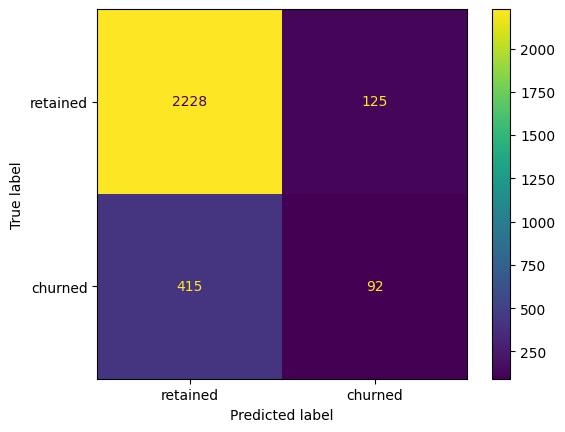

In [36]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot();



* **True Negative (TN): 2228**

   * These are the instances correctly predicted as not churned by the model.
   * In our case, the model accurately identified 2228 retained users.

* **False Positive (FP): 125**

 * These are instances where the model incorrectly predicted as **"churned"** when the actual outcome was **"retained"**.

* **False Negative (FN): 415**

 * These instances represent cases where the model predicted "retained", but the actual outcome was "churned", indicating a significant number of false negatives.
 * The model predicted three times more false negatives (415) than false positives (92).

* **True Positive (TP): 92**

 * These are instances where the model correctly identified **92** churned users, which is significantly fewer compared to the number of false negatives.

The ratio of false negatives to false positives is approximately **4.51** (415/92 ≈ 4.51), indicating that false negatives occur more frequently than false positives in the model's predictions.




# **Feature Importance**
The **plot_importance()** function in **XGBoost** allows us to visualize the important features of our trained model. This visualization indicates which features are most influential in making predictions, providing insights into the key factors driving the model's decisions.

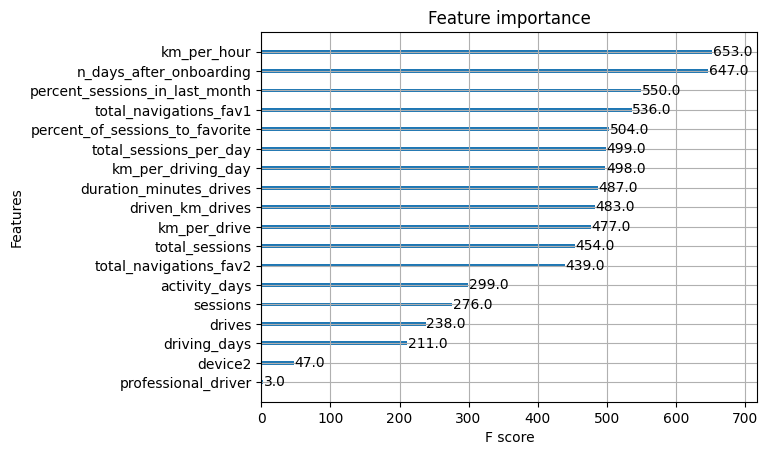

In [37]:
# Plot feature importance for XGBoost model
plot_importance(xgb_cv.best_estimator_);

* According to the feature importance of the XGBoost model, **`km_per_hour`** significantly influences predictions. Unlike logistic regression, which heavily weighted a single feature (**`activity_days`**), the **XGBoost** model makes use of many features.

* In our logistic regression model, **`professional_driver`** was relatively important, ranking third, but in the **XGBoost** model, it is the **least important feature**.

* This highlights that important features can vary between models, emphasizing the need for a thorough understanding of feature relationships with the dependent variable. Such discrepancies often arise due to complex feature interactions.

Among the top three most important features, two are engineered (**`km_per_hour`** and **`percent_sessions_in_last_month`**). Similarly, among the top five, three are engineered. Engineered features account for six out of the top 10 features, underscoring the importance of feature engineering.


# **Precision-Recall Curve**
Our model's performance was suboptimal, with a recall score of **0.18** indicating that it can only identify **18%** of actual churned users. To improve our recall score, one strategy is to lower the decision threshold.

By default, the threshold is set to **0.5** for most classification algorithms, including scikit-learn. This means that if our model predicts that a user has a **50%** probability or higher of churning, it assigns a predicted value of **1**, indicating **churn**. However, in cases of imbalanced datasets where the minority class (churned users) is of interest, this threshold may not be ideal.

Now, let's have a look at the precision-recall curve for the XGBoost model on the test data.






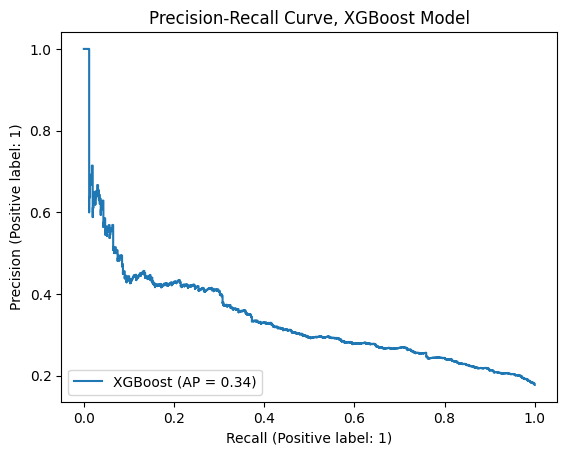

In [38]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(xgb_cv.best_estimator_,
                                                X_test, y_test, name='XGBoost')
plt.title('Precision-Recall Curve, XGBoost Model');

The precision-recall curve plot illustrates that as recall increases, precision decreases, highlighting the trade-off between these two metrics for the XGBoost model. This trade-off is typical in classification tasks, where achieving higher recall often comes at the cost of lower precision, and vice versa.

In our Waze user churn prediction model, false negatives pose a significant issue because missing the chance to take proactive measures to prevent churn is costly, making recall crucial in this context. On the other hand, false positives means sending notifications to users who won't actually churn, which is less risky.

Using the precision-recall curve as a guide, we found that aiming for a recall of approximately **50%** corresponds to a precision of around **30%**. Therefore, we decided to lower the threshold from **0.5** to **0.18** to prioritize recall in our predictions. This adjustment is intended to enhance our model's recall performance, and we will assess whether this leads to an overall improvement in model performance.

To do this, we will obtain probabilities using the **predict_proba()** function, which returns a 2-D array of probabilities. Each row in this array represents a user, and the first column corresponds to the probability of the negative class (**Retained**), while the second column corresponds to the probability of the positive class (**churned**).



In [39]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.94572806, 0.05427192],
       [0.57626796, 0.42373207],
       [0.98132175, 0.01867823],
       ...,
       [0.8135836 , 0.18641639],
       [0.9661311 , 0.03386891],
       [0.7386279 , 0.26137212]], dtype=float32)

Any users who have a **probability value ≥ 0.18** in the second column (**churned class**) of the **predict_proba()** output will be assigned a predicted value of **1**, indicating that they are **predicted to churn**.

In [40]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.18 else 0 for x in probs])
new_preds

array([0, 1, 0, ..., 1, 0, 1])

In [41]:
# Get evaluation metrics for when the threshold is 0.18
get_test_scores('XGB, threshold 0.18', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold 0.18",0.293668,0.530572,0.378074,0.690559



* With the lowered threshold of **0.18**, we observed notable improvements in the recall score, increasing from **0.18** to **0.53**.
* However, precision decreased from **0.42** to **0.29** with the lowered threshold, highlighting the trade-off where higher recall comes at the expense of precision.
* The F1 score improved from **0.23** to **0.37**, indicating a better balance between precision and recall compared to the default threshold.
* Notably, the accuracy decreased from **0.81** to **0.69** when lowering the threshold.

By lowering the decision threshold to **0.18**, we aimed to achieve a recall of around **0.50**, meaning that the model now captures **50%** of users who actually churn. However, this adjustment also reduced precision, indicating that when the model predicts a user will churn, it is correct only about **29%** of the time. This trade-off highlights the importance of balancing recall and precision based on specific business objectives and priorities in a classification task.

# **Conclusion**

In this project, we implemented a **Random forest** and **XGBoost** model using a **60/20/20** split methodology, dividing the data into **training, validation, and test sets**. Through validation set predictions, we identified XGBoost as the champion model due to its good performance compared to random forest.

Subsequently, we assessed the model's performance on the test set, analyzed confusion metrics, and examined feature importance. To enhance recall, we conducted experiments by lowering the decision threshold, evaluating the model's responsiveness to this adjustment. Now, let's proceed to answer some questions.

# **Questions**
## **Would you recommend that Waze use this model? Why or why not?**
* Both our models, Random Forest and XGBoost, did not achieve satisfactory performance scores. While XGBoost outperformed Random Forest, its performance was still below the deployment threshold. Our attempt to improve recall resulted in an increase, albeit at the expense of precision.

* The decision to use the model depends on its intended purpose. If the model is intended to inform critical business decisions, then neither model meets the necessary standards due to the low recall and moderate precision observed. Instead, leveraging the model for further exploration and using the insights gained for refinement could provide valuable direction.


## **What additional features would you like to have to help improve the model?**
* To improve our ability to predict user churn, we should gather data on usage patterns, including the **times of day** and **days of the week** when users are most or least active.

* We also need access to location history to identify common routes, and frequent destinations.

* Additionally, collecting feedback and reviews will help us assess user satisfaction levels, pain points, and understand the reasons behind user dissatisfaction.

Gathering and analyzing this information will enhance our understanding of user behavior and improve our churn prediction capabilities.


## **What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?**
* Logistic regression models are easier to interpret. They assign coefficients to each predictor variable, which provides clear insights into the influence of each feature on the model's predictions.

* The magnitude and sign (positive or negative) of these coefficients directly reflect the impact of the corresponding features on the predicted probability of the target class.

* Positive coefficients indicate a positive relationship with the target variable, while negative coefficients indicate a negative relationship.

* This transparency enables stakeholders to understand which features are most influential in driving the model's decisions.

## **What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?**
* Ensemble tree-based models like **Random Forest** or **XGBoost** offer several advantages over logistic regression for classification tasks.

* These models are renowned for their predictive accuracy, making them great predictors in many scenarios. They are robust to outliers and extreme values, requiring fewer assumptions about the underlying data distribution.

* Unlike logistic regression, which assumes linearity, tree-based models can effectively model complex non-linear relationships within the data.

* Additionally, tree-based models are well-suited for large datasets with numerous features, overcoming the challenges of the curse of dimensionality often encountered by logistic regression.

